# bike sharing-预测单月份

author:[chester.wang](https://github.com/chesterwang)

修改:
- 2017-01-26 添加toc，目录等内容

# toc

1. [特征处理](#特征处理)
2. [模型训练/预测/评估](#模型训练/预测/评估)
3. [检查模型预测较差的部分](#检查模型预测较差的部分)

In [2]:
%pylab
%matplotlib inline
import pandas as pd
import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.neural_network as nn
import sklearn.ensemble as es
import sklearn.kernel_ridge as kr
import sklearn.metrics as mt
import sklearn.cross_validation as cv
import sklearn.preprocessing as pp
#需要添加最近的信息,但是要考虑到问题如何逐步前进预测以及缺失最近数据的情况
#针对凌晨三点,数量很少的情况,由于其波动性对log值造成的影响较大,考虑如何克服?


#对于极端天气情况,因为单个月份中,极端天气出现情况较少,所以极端天气需要另外进行学习

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


# 特征处理
[toc](#toc)

In [3]:

def replace_mean_target(df,col_name,target_name,new_col_name):
    grouped=df[[col_name,target_name]].groupby(col_name)
    mean_count_dict=grouped.aggregate(np.mean)[target_name].to_dict()
    df[new_col_name] = df.apply(lambda x:mean_count_dict[x[col_name]],axis=1)
#     return mean_count_dict
def discretize(df,col):
    for idx in df[col].value_counts().index:
        new_col_name = col+"__"+str(idx)
        df[new_col_name] = df[col].apply(lambda x:1 if(x==idx) else 0)

df = pd.read_csv("data/train.csv",sep=",",header=0,parse_dates=[0])
df.dtypes
# df = df[df.holiday!=1]


df["hour"]=df.apply(lambda x:x["datetime"].hour,axis=1)
df["hour_segment"]=df.apply(lambda x:
                            "1" if(x["datetime"].hour==0) else 
                            "".join([str(idx) if(x["datetime"].hour >segment[0] and x["datetime"].hour <=segment[1]) else ""
                                     for idx,segment in 
                                     {1:[0,5],2:[5,10],3:[10,14],4:[14,20],5:[20,23]}.items()]),
                            axis=1)

df["windspeed_segment"]=df.apply(lambda x:
                            "".join([str(idx) if(x["windspeed"] >segment[0] and x["windspeed"] <=segment[1]) else ""
                                     for idx,segment in 
                                     {1:[-1,10],2:[10,20],3:[20,30],4:[30,40],5:[40,60]}.items()]),
                            axis=1)
df["windspeed_segment"] = df["windspeed_segment"].apply(lambda x:int(x))
replace_mean_target(df,"windspeed_segment","count","windspeed_segment_avg")

# df["windspeed_segment_max"] = df.apply(lambda x: 1 if(x["windspeed"] >40) else 0,  axis=1)
# replace_mean_target(df,"windspeed_segment_max","count","windspeed_segment_max")

# 湿度 
df["humidity_segment"] = df.apply(lambda x:int(x["humidity"]/ 10),axis=1)
replace_mean_target(df,"humidity_segment","count","humidity_segment_avg")

discretize(df,"weather")


# df =  df[(df["hour_segment"] == "5") | (df["hour_segment"] == "1")]
# df.index = range(0,df.shape[0])

#         df[col+"__"+idx] = df[[col]].apply(lambda x:1 if(x==idx) else 0,axis=1)

df["weather_windspeed_segment"] = df.apply(lambda x:str(x["weather"]) + "_" + str(x["windspeed_segment"]),axis=1 )
replace_mean_target(df,"weather_windspeed_segment","count","weather_windspeed_segment")

df["weekday"]=df.apply(lambda x:x["datetime"].weekday(),axis=1)
df["weekend"]=df.apply(lambda x:1 if x["weekday"] in [0,1]  else 0,axis=1)
df["month"]=df.apply(lambda x:x["datetime"].month,axis=1)
df["year"]=df.apply(lambda x:x["datetime"].year,axis=1)
# df["weekday_hour_segment"] = df.apply(lambda x:log(x["count"]),axis=1)
df["weekday_hour_segment"] = df["weekday"].apply(lambda x:str(x)) + df["hour_segment"]
replace_mean_target(df,"weekday_hour_segment","count","weekday_hour_segment")

df["weekend_hour_segment"] = df["weekend"].apply(lambda x:str(x)) + df["hour_segment"]
replace_mean_target(df,"weekend_hour_segment","count","weekend_hour_segment")

df["weekday_hour"] = df["weekday"].apply(lambda x:str(x)) + df["hour"].apply(lambda x:str(x))
replace_mean_target(df,"weekday_hour","count","weekday_hour")

df["weekend_hour"] = df["weekend"].apply(lambda x:str(x)) + df["hour"].apply(lambda x:str(x))
replace_mean_target(df,"weekend_hour","count","weekend_hour")

df["weekday_weather"] = df["weekday"].apply(lambda x:str(x)) + df["weather"].apply(lambda x:str(x))
replace_mean_target(df,"weekday_weather","count","weekday_weather_avg")

# 周一并且天气糟糕, 天气对周一影响大
df["monday_bad_weater"] = df.apply(lambda x: 1 if(x["weekday"]==2 and x["weather"]!=1) else 0,axis=1)

#是否一月份周六
df["january_saturday"] = df.apply(lambda x: 1 if(x["weekday"]==0 and x["month"]==1) else 0,axis=1)


df["count_log"] = df.apply(lambda x:log(x["count"]+1),axis=1)


# 模型训练/预测/评估

In [4]:

feat_col = ["season","holiday","workingday","weather","temp","atemp","humidity","windspeed",
           "hour","weekday","month","hour_segment","weekday_hour_segment","weekday_hour","weekday_weather",
           "weekend","weekend_hour_segment","weekend_hour","weather_windspeed_segment","windspeed_segment_avg",
           "humidity_segment_avg","monday_bad_weater","january_saturday","humidity_segment"]

df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,year,weekday_hour_segment,weekend_hour_segment,weekday_hour,weekend_hour,weekday_weather,weekday_weather_avg,monday_bad_weater,january_saturday,count_log
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,...,2011,42.969697,29.173237,98.212121,64.515337,51,210.559099,0,0,2.833213
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,...,2011,42.969697,29.173237,70.015152,41.248466,51,210.559099,0,0,3.713572
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,...,2011,42.969697,29.173237,50.348485,28.629283,51,210.559099,0,0,3.496508
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,...,2011,42.969697,29.173237,23.060606,14.310127,51,210.559099,0,0,2.639057
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,...,2011,42.969697,29.173237,7.666667,6.689873,51,210.559099,0,0,0.693147
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,...,2011,42.969697,29.173237,8.515152,18.393189,52,182.992718,0,0,0.693147
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,...,2011,129.212121,198.572393,21.121212,67.953988,51,210.559099,0,0,1.098612
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,...,2011,129.212121,198.572393,47.242424,187.101227,51,210.559099,0,0,1.386294
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,...,2011,129.212121,198.572393,117.560606,328.852761,51,210.559099,0,0,2.197225
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,...,2011,129.212121,198.572393,190.606061,218.049080,51,210.559099,0,0,2.708050


In [ ]:

models = {
#           "lr":lm.LinearRegression(fit_intercept=True),
#           "ridge":lm.Ridge(),
          "dtree":tree.DecisionTreeRegressor(max_depth=10),
          "rf":es.RandomForestRegressor(n_estimators=100,max_depth=7),
          "bag":es.BaggingRegressor(n_estimators=50),
          "gb":es.GradientBoostingRegressor(n_estimators=100),
#           kr.KernelRidge()
         }
target_col="count_log"
kfs = cv.KFold(df.index.size,n_folds=5,random_state=13)

month_index = [(a,b) for a in range(1,12) for b in [2011,2012]]
score_total=[]
evaluation_total=[]
testdf_total = pd.DataFrame()
for month,year in month_index:
    innerdf = df[(df["year"]==year) & (df["month"]==month)]
    bound=int(innerdf.index.size*0.7)
    trainidx=range(0,bound)
    testidx=range(bound,innerdf.index.size)

    traindf = innerdf.iloc[trainidx]
    testdf = innerdf.iloc[testidx]
    traindf[feat_col].as_matrix()
    traindf[target_col].as_matrix()
    model = es.RandomForestRegressor(n_estimators=150,max_depth=7)
#     model = es.BaggingRegressor(n_estimators=50)
    model.fit(traindf[feat_col].as_matrix(),traindf[target_col].as_matrix())
    score = model.score(testdf[feat_col].as_matrix(),testdf[target_col].as_matrix())
    hh = zip(model.predict(testdf[feat_col].as_matrix()),testdf[target_col].as_matrix())
    #     evaluation = sqrt(mean(map(lambda x:(log(x[0]+1)-log(x[1]+1))**2,hh)))
    evaluation = sqrt(mean(map(lambda x:(x[0]-x[1])**2,hh)))
#     print score,evaluation
    evaluation_total.append(evaluation)
    testdf["predict"] = model.predict(testdf[feat_col].as_matrix())
    testdf_total = pd.concat([testdf_total,testdf])

print(np.mean(evaluation_total),np.std(evaluation_total))

# (0.41046256413538756, 0.092885128896212629)
# (0.34232312169879764, 0.095852740079917578)
# (0.34041302842622073, 0.096973980932463136)
#(0.33965869141140664, 0.095912643479322893)
#(0.33882754159198886, 0.097971803837636012)
# (0.32694368967086468, 0.077421716863455739)

#午夜
#(0.33769785212952419, 0.083053510822506033)
#(0.33717464046532464, 0.084172117312798764)
#(0.33632597814067, 0.082605032336921971)
#(0.33842216498133149, 0.08447841651066347)
#(0.33785112721019472, 0.083662348125093114)

# 检查模型预测较差的部分

In [42]:
df[feat_col].dtypes

season                         int64
holiday                        int64
workingday                     int64
weather                        int64
temp                         float64
atemp                        float64
humidity                       int64
windspeed                    float64
hour                           int64
weekday                        int64
month                          int64
hour_segment                  object
weekday_hour_segment         float64
weekday_hour                 float64
weekday_weather               object
weekend                        int64
weekend_hour_segment         float64
weekend_hour                 float64
weather_windspeed_segment    float64
windspeed_segment             object
humidity_segment_avg         float64
dtype: object

/usr/local/lib/python2.7/dist-packages/ipykernel-4.3.1-py2.7.egg/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa8817f650>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ffa87692b90>]], dtype=object)

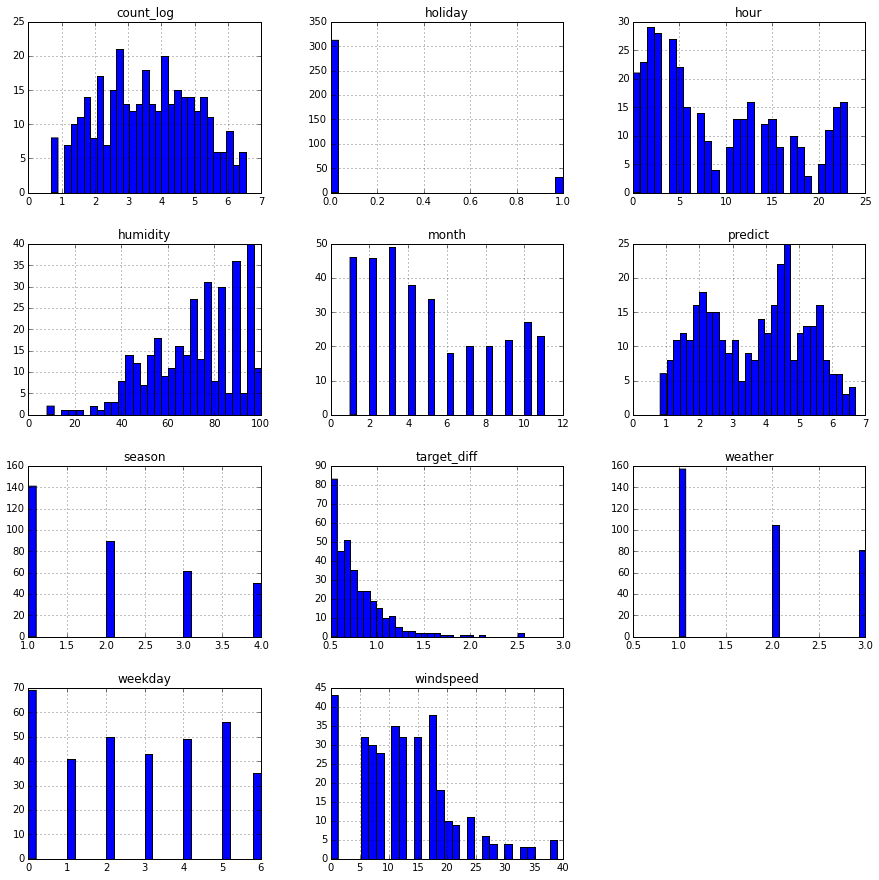

In [94]:
testdf_total_minus=testdf_total.copy()
testdf_total_minus["target_diff"] = np.abs(testdf_total.predict - testdf_total.count_log)
aaa = testdf_total_minus.sort(columns=["target_diff"],ascending=False)
aaa[aaa.target_diff>0.5][["season","weekday",
                        "month","hour","holiday","weather","humidity",
                        "count_log","predict","target_diff","windspeed"]].hist(bins=30,figsize=(15,15))


In [ ]:
##气温骤降的数据一定是有问题的,预测也不对
# traindf.index=traindf["datetime"]
# testdf.index=testdf["datetime"]


In [54]:
df["windspeed"].max()

56.996899999999997

In [ ]:
traindf.iloc[0:170][["count"]].plot(figsize=(15,15))

- 上班时间,周一到周五分析
    - 在上班和下班的高峰期,weather对count影响较小(添加特征 区段 0-5 5-10 10-14 14-0)
    - 在中午,weather对count影响较大,相对来说,这种程度以周五为最大,周一最小
    - 下午下班时间,weather对count影响,周五最大,周一最小
    - 上午上班时间,蓝绿重合,即说明蓝绿天气基本无影响
    - 上午上班时间,红色以周四周三最突出,其他四天差异不大
- 周末
    - 周六weather影响较大

- 假期非常特殊

In [ ]:
plt.figure()
listdf = [ df[df["weather"]==weather].groupby(["weekday","hour"])[["count"]].agg(np.mean).rename(columns={"count":"weather"+str(weather)}).iloc[0:40]#.plot(figsize=(15,15))
 for weather in [1,2,3]]
pd.concat(listdf,axis=1).plot(figsize=(15,15))



In [ ]:
# df = pd.read_csv("data/train.csv",sep=",",header=0,parse_dates=[0])

df.iloc[aaa[aaa.target_diff>1].index]

In [ ]:
#20110118缺少上午的数据
#预测最差的一个 风速很大

In [ ]:
df.windspeed.hist()